In [67]:
import os
import re
import nltk
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
from src.news_data_plotter import NewsDataPlotter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

In [42]:
file_path = "../data/raw/raw_analyst_ratings.csv"

df = pd.read_csv(file_path)
df.head(50)

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
5,5,"CFRA Maintains Hold on Agilent Technologies, L...",https://www.benzinga.com/news/20/05/16095163/c...,vishwanath@benzinga.com,2020-05-22 11:23:25-04:00,A
6,6,"UBS Maintains Neutral on Agilent Technologies,...",https://www.benzinga.com/news/20/05/16094027/u...,vishwanath@benzinga.com,2020-05-22 09:36:20-04:00,A
7,7,Agilent Technologies shares are trading higher...,https://www.benzinga.com/wiim/20/05/16093805/a...,Benzinga Newsdesk,2020-05-22 09:07:04-04:00,A
8,8,Wells Fargo Maintains Overweight on Agilent Te...,https://www.benzinga.com/news/20/05/16093505/w...,vishwanath@benzinga.com,2020-05-22 08:37:59-04:00,A
9,9,10 Biggest Price Target Changes For Friday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-05-22 08:06:17-04:00,A


In [43]:
df["date"] = pd.to_datetime(df["date"], format="ISO8601", utc=True)
df["date_only"] = df["date"].dt.date
df["time_only"] = df["date"].dt.time

df.head(100)

,Unnamed: 0,headline,url,publisher,date,stock,date_only,time_only
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05,14:30:54
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03,14:45:20
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26,08:30:07
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22,16:45:06
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22,15:38:59
...,...,...,...,...,...,...,...,...
95,95,Barclays Maintains Equal-Weight on Agilent Tec...,https://www.benzinga.com/news/19/10/14566662/b...,Vick Meyer,2019-10-09 04:00:00+00:00,A,2019-10-09,04:00:00
96,96,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-08 04:00:00+00:00,A,2019-10-08,04:00:00
97,97,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-02 04:00:00+00:00,A,2019-10-02,04:00:00
98,98,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/09/14...,Benzinga Newsdesk,2019-09-05 04:00:00+00:00,A,2019-09-05,04:00:00


In [44]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns

Index(['headline', 'url', 'publisher', 'date', 'stock', 'date_only',
       'time_only'],
      dtype='object')

In [45]:
df.shape

(1407328, 7)

In [70]:
# what is the timeframe where the date has been taken from
# TODO: what year has the date been taken on?  Can I see some trend based on this?
latest_date = df["date_only"].max()
earliest_date = df["date_only"].min()

#  get the years to do some trend analysis over time
years = latest_date.year - earliest_date.year

print(f"The data is collected on the range of {earliest_date} - {latest_date} for a span of {years}")

The data is collected on the range of 2009-02-14 - 2020-06-11 for a span of 11


In [48]:
df["headline_length"] = df["headline"].apply(lambda x: len(x))
df.head(100)

,headline,url,publisher,date,stock,date_only,time_only,headline_length
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05,14:30:54,39
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03,14:45:20,42
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26,08:30:07,29
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22,16:45:06,44
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22,15:38:59,87
...,...,...,...,...,...,...,...,...
95,Barclays Maintains Equal-Weight on Agilent Tec...,https://www.benzinga.com/news/19/10/14566662/b...,Vick Meyer,2019-10-09 04:00:00+00:00,A,2019-10-09,04:00:00,83
96,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-08 04:00:00+00:00,A,2019-10-08,04:00:00,251
97,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-02 04:00:00+00:00,A,2019-10-02,04:00:00,243
98,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/09/14...,Benzinga Newsdesk,2019-09-05 04:00:00+00:00,A,2019-09-05,04:00:00,304


In [73]:
min_headline_length = df["headline_length"].min()
max_headline_length = df["headline_length"].max()

bins = np.linspace(min_headline_length, max_headline_length, 4)
labels = ["Short", "Medium", "Long"]

df["headline_length_category"] = pd.cut(df["headline_length"], bins=bins, labels=labels)

df.head(100)

[  3.         172.66666667 342.33333333 512.        ]


,headline,url,publisher,date,stock,date_only,time_only,headline_length,headline_length_category
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05,14:30:54,39,Short
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03,14:45:20,42,Short
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26,08:30:07,29,Short
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22,16:45:06,44,Short
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22,15:38:59,87,Short
...,...,...,...,...,...,...,...,...,...
95,Barclays Maintains Equal-Weight on Agilent Tec...,https://www.benzinga.com/news/19/10/14566662/b...,Vick Meyer,2019-10-09 04:00:00+00:00,A,2019-10-09,04:00:00,83,Short
96,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-08 04:00:00+00:00,A,2019-10-08,04:00:00,251,Medium
97,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-02 04:00:00+00:00,A,2019-10-02,04:00:00,243,Medium
98,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/09/14...,Benzinga Newsdesk,2019-09-05 04:00:00+00:00,A,2019-09-05,04:00:00,304,Medium


In [72]:
print(f"The headlines length were from: {min_headline_length} - {max_headline_length}")

The headlines length were from: 3 - 512


headline_length_category
Short     1355710
Medium      50940
Long          666
Name: count, dtype: int64


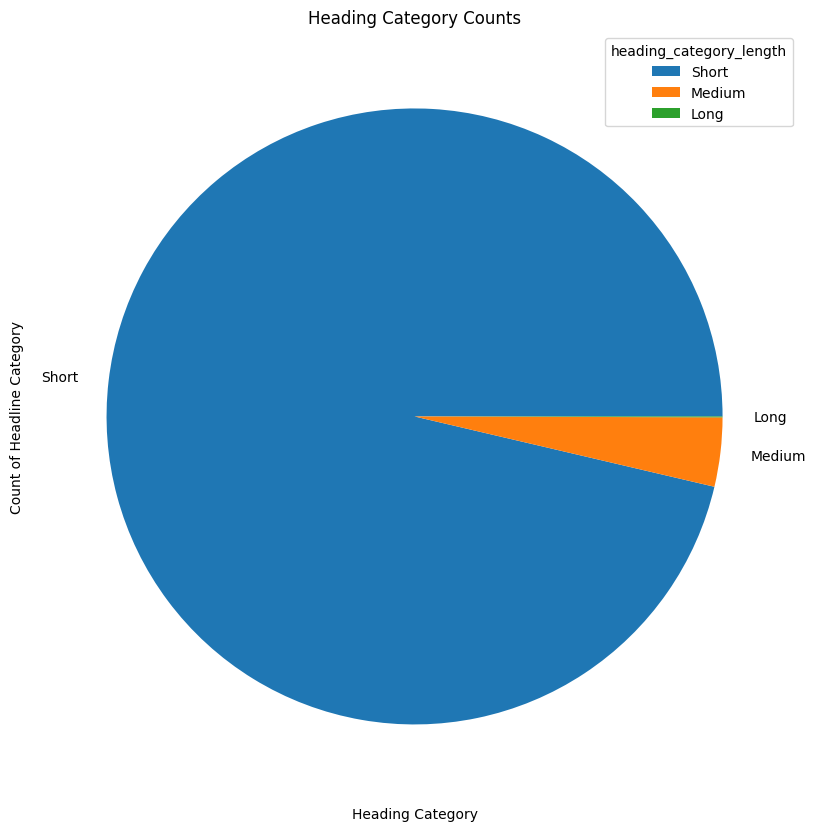

In [82]:
result = df["headline_length_category"].value_counts()
print(result.head())

plt.figure(figsize=(20, 10))
plt.title("Heading Category Counts")

result.plot(kind='pie')

plt.legend(title='heading_category_length')

plt.xlabel('Heading Category')
plt.ylabel('Count of Headline Category')

plt.savefig('./images/Headline_Category_Pie_Chart.png', format='png')

plt.show()

## Analysis of Publication Trends

In [51]:
news_count_per_day = df.groupby(['date_only']).size().reset_index(name='news_count')

news_count_per_day.columns = ["date", "news_count"]
news_count_per_day["date"] = pd.to_datetime(news_count_per_day["date"], format="ISO8601", utc=True)

news_count_per_day["year"] = news_count_per_day["date"].dt.year
news_count_per_day["month"] = news_count_per_day["date"].dt.month

news_count_per_day

,date,news_count,year,month
0,2009-02-14 00:00:00+00:00,1,2009,2
1,2009-04-27 00:00:00+00:00,2,2009,4
2,2009-04-29 00:00:00+00:00,1,2009,4
3,2009-05-22 00:00:00+00:00,1,2009,5
4,2009-05-27 00:00:00+00:00,6,2009,5
...,...,...,...,...
3950,2020-06-07 00:00:00+00:00,25,2020,6
3951,2020-06-08 00:00:00+00:00,765,2020,6
3952,2020-06-09 00:00:00+00:00,803,2020,6
3953,2020-06-10 00:00:00+00:00,807,2020,6


In [52]:
news_count_per_month = news_count_per_day.groupby(["month", "year"]).size().reset_index()
news_count_per_month.columns = ["month", "year", "news_count"]
news_count_per_month

,month,year,news_count
0,1,2010,31
1,1,2011,31
2,1,2012,29
3,1,2013,31
4,1,2014,31
...,...,...,...
131,12,2015,30
132,12,2016,29
133,12,2017,31
134,12,2018,31


In [53]:
years_count = news_count_per_month.pivot_table(index="year", columns="month", values="news_count", fill_value=0)

months_of_year = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

years_count.columns = [month[:3] for month in months_of_year]
years_count

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2009,0.0,1.0,0.0,2.0,4.0,11.0,11.0,26.0,28.0,28.0,30.0,28.0
2010,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,30.0,30.0,31.0
2011,31.0,27.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,29.0,29.0,30.0
2012,29.0,28.0,30.0,29.0,30.0,30.0,31.0,31.0,29.0,31.0,30.0,30.0
2013,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
2014,31.0,28.0,31.0,30.0,31.0,29.0,31.0,31.0,30.0,31.0,30.0,31.0
2015,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,30.0
2016,31.0,29.0,31.0,30.0,31.0,30.0,29.0,31.0,30.0,31.0,30.0,29.0
2017,29.0,28.0,31.0,30.0,31.0,30.0,31.0,30.0,29.0,31.0,28.0,31.0


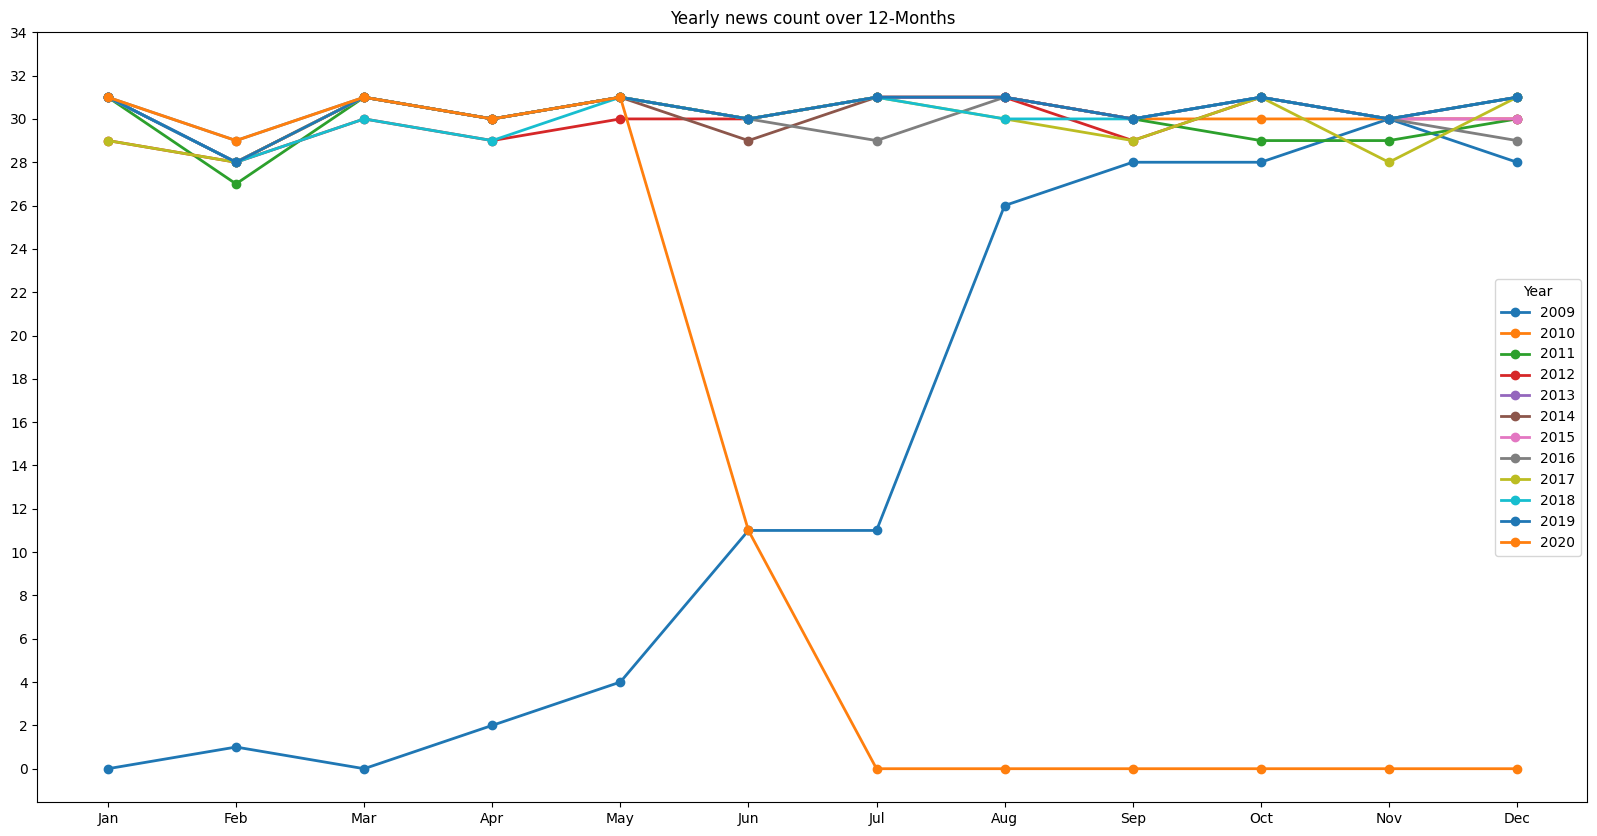

In [54]:
x_label, y_label = 'Months', 'Total News Published'
plotter = NewsDataPlotter(years_count)

# Create the figure to plot on
plt.figure(figsize=(20, 10))

# Optionally set the grid
plt.grid(True)

for year in years_count.index:
    plotter.plot_year_data(year, x_label, y_label)

# add the legend after all lines are plotted
plt.legend(title='Year')

# add the title to the entire plot
plt.title(f"Yearly news count over 12-Months")

# Save the figure as an image
plt.savefig('./images/All_Years_News_Month_News_Count_Plog.png', format='png')

# Show the plot
plt.show()

## Analysis of Publishers

In [68]:
email_regex = r'/^([a-z0-9_\.-]+)@([\da-z\.-]+)\.([a-z\.]{2,6})$/'
# df["publisher"].str.contains(email_regex, regex=True)

is_valid = lambda x : re.match(email_regex, x) is not None

publishers = df["publisher"]
publishers[publishers.apply(is_valid)]

Series([], Name: publisher, dtype: object)

<Axes: ylabel='Frequency'>

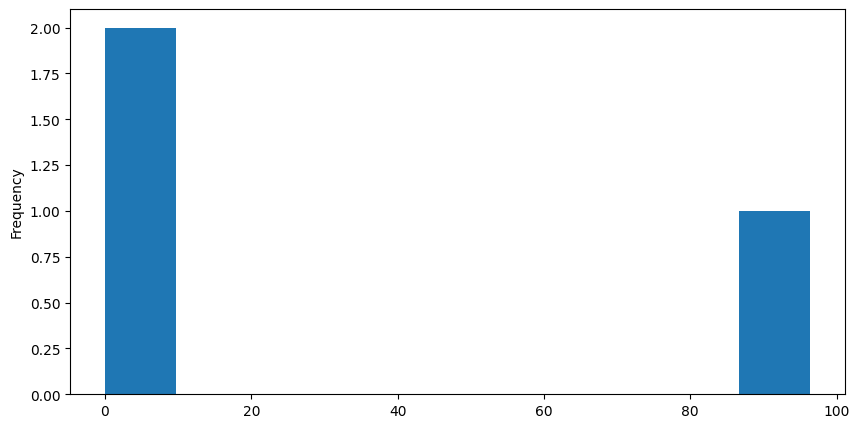

In [56]:
headline_category = df["headline_length_category"].value_counts().to_frame()
headline_category["percentile"] = headline_category["count"].apply(lambda x: (x / headline_category.sum()) * 100)

headline_category["percentile"].plot(kind="hist", figsize=(10, 5))

In [83]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/leuel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [84]:
# Make a copy for the sentiment analysis
sentiment_df = df.copy()

In [85]:
sia = SentimentIntensityAnalyzer()

In [88]:
# calculate the sentiment scores of the headlines
sentiment_df["sentiment"] = sentiment_df["headline"].apply(
    lambda x: sia.polarity_scores(text=x)["compound"]
)
sentiment_df

,headline,url,publisher,date,stock,date_only,time_only,headline_length,headline_length_category,sentiment,sentiment_category
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05,14:30:54,39,Short,0.0000,neutral
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03,14:45:20,42,Short,0.0000,neutral
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26,08:30:07,29,Short,0.0000,neutral
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22,16:45:06,44,Short,0.0000,neutral
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22,15:38:59,87,Short,0.2960,neutral
...,...,...,...,...,...,...,...,...,...,...,...
1407323,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 04:00:00+00:00,ZX,2011-08-29,04:00:00,38,Short,0.2023,neutral
1407324,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 04:00:00+00:00,ZX,2011-06-22,04:00:00,52,Short,-0.3818,postive
1407325,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 04:00:00+00:00,ZX,2011-06-21,04:00:00,56,Short,0.0000,neutral
1407326,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 04:00:00+00:00,ZX,2011-06-21,04:00:00,54,Short,0.0000,neutral


In [89]:
sentiment_df["sentiment_category"] = pd.cut(
    sentiment_df["sentiment"], bins=3, labels=["positive", "neutral", "negative"]
)
sentiment_df.head()

,headline,url,publisher,date,stock,date_only,time_only,headline_length,headline_length_category,sentiment,sentiment_category
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,2020-06-05,14:30:54,39,Short,0.000,neutral
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,2020-06-03,14:45:20,42,Short,0.000,neutral
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,2020-05-26,08:30:07,29,Short,0.000,neutral
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,2020-05-22,16:45:06,44,Short,0.000,neutral
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,2020-05-22,15:38:59,87,Short,0.296,neutral


In [92]:
category_counts = sentiment_df["sentiment_category"].value_counts()
category_counts

sentiment_category
neutral     1090395
negative     213016
positive     103917
Name: count, dtype: int64

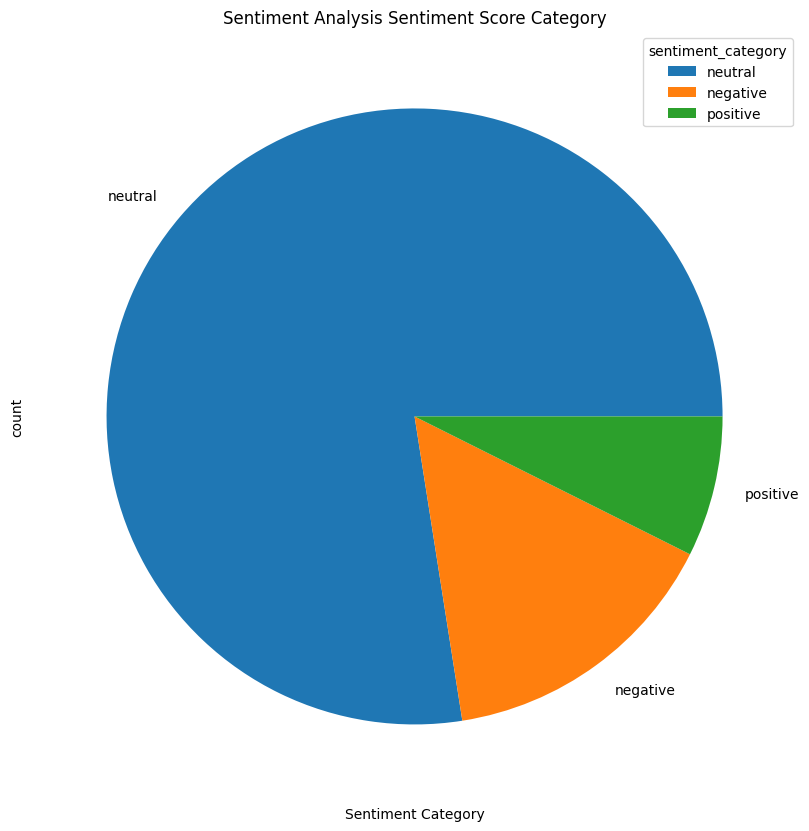

In [102]:
plt.figure(figsize=(20, 10))
plt.title("Sentiment Analysis Sentiment Score Category")

plt.xlabel("Sentiment Category")
plt.ylabel("Sentiment Category Count")

category_counts.plot(kind='pie')

plt.legend(title='sentiment_category')
plt.savefig('./images/Sentiment_Score_Category_Pie_Chart.png', format='png')

plt.show()
